In [154]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.decomposition import PCA

In [155]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

primary_dealer_features = [
    'HHI_number', 'TimeToMaturity', 'TimeSinceOffering', 'Offering_amount',
       'Rating', 'JunkDummy', 'UnratedDummy', 'Enhanced', 'Redeemable',
       'SinkingFund', 'BOND_COUPON', 'IQ_CDS_availability', 'COVENANTS',
        'AvgTransVol', 'TRADES_VOL', 'amihud_ILLIQ_trades',
       'price_dispersion_volumeweighted', 'EquityValue', 'DefaultBarrier2',
       'NumberEmployees', 'IndDis1', 'IndDis2', 'Slope', 'X90DayDR', 'GDP',
       'TradeSize_Retail', 'TradeSize_SmallInstitutional',
       'Seniority_SeniorSubordinate', 'Seniority_SeniorUnsecured',
       'Seniority_SubordinateJunior', 'Default_DefRating',
       'Default_Distressed_exchange', 'Default_Liquidation_C7',
       'Default_RiskRating'
]

In [156]:
def create_colored_chart(model):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2 or feature in primary_dealer_features:
            colors.append('blue')
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    # Create a custom legend
    handles = [
        plt.Rectangle((0, 0), 1, 1, color='blue'),
        plt.Rectangle((0, 0), 1, 1, color='purple'),
    ]
    labels = [
            'Financial Data', 
            'New Metrics',
            ]
    # Add the legend
    plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [415]:
def compute_scores(df, model, transformation, significant=False):

    # Function to normalize a subset of parameters
    def normalize_params(params, features):
        subset_params = np.abs(params[features])
        return subset_params / np.sum(subset_params)
    
    def finalize_weights(weights, features, params):
        # if features has negative values, set the weights to negative
        for feature in features:
            if params[feature] < 0:
                weights[feature] = -weights[feature]
                print(f"Setting {feature} to negative")
        return weights

    def pca_weights(df, features, n_components=1):
        # Run PCA on the selected features
        pca = PCA(n_components=n_components)
        pca.fit(df[features])

        # Use the loadings of the first principal component as weights
        weights = pca.components_[0]
        
        # Normalize weights to sum to 1
        weights = weights / np.sum(np.abs(weights))
        return weights

    # Features used in each score
    mts_features = [
        'language_accessibility_presentation', 
        'language_accessibility_qna',
        'responsiveness', 
        #'depth', 
        'evasiveness', 
        'uncertainty', 
        'vagueness', 
        'confusion', 
        'realization'
        ]

    cami_features = [
        'debt_leverage_stress', 
        'confidence', 
        'optimistic', 
        'pessimistic',
        'recovery_strategies', 
        'legal_issues', 
        'macroeconomic',
        'industry_positioning', 
        'operational_trends', 
        'liquidity_position',
        'asset_quality',
        'anger', 
        'fear',
        #'pride', 
        #'approval', 
        'optimism'
        ]
    
    aus_features = [
        'analyst_concerns', 
        'analyst_satisfaction',
        'disappointment_analysts', 
        'anger_analysts', 
        'embarrassment_analysts', 
        'remorse_analysts',
        #'approval_analysts', 
        'relief_analysts', 
        'excitement_analysts',
        'caring_analysts', 
        #'realization_analysts',
        'sadness_analysts',
        ]

    if significant:
        significant_features = model.pvalues[model.pvalues < 0.05].index
        # reduce to only significant features
        mts_features = list(set(mts_features).intersection(significant_features))
        print(mts_features)
        cami_features = list(set(cami_features).intersection(significant_features))
        aus_features = list(set(aus_features).intersection(significant_features))

    if transformation == 'pca':
        mts_weights = pca_weights(df, mts_features)
        cami_weights = pca_weights(df, cami_features)
        aus_weights = pca_weights(df, aus_features)

    elif transformation == 'model_weights':

        # Get the absolute values of the coefficients and subtract standard error
        abs_params = np.abs(model.params)

        # Normalize parameters for each score
        mts_weights = normalize_params(abs_params, mts_features)
        cami_weights = normalize_params(abs_params, cami_features)
        aus_weights = normalize_params(abs_params, aus_features)

        # Finalize the weights
        mts_weights = finalize_weights(mts_weights, mts_features, model.params)
        cami_weights = finalize_weights(cami_weights, cami_features, model.params)
        aus_weights = finalize_weights(aus_weights, aus_features, model.params)

    # Management Transparency Score (MTS)
    df['MTS'] = np.dot(df[mts_features], mts_weights)

    # Crisis Awareness and Management Index (CAMI)
    df['CAMI'] = np.dot(df[cami_features], cami_weights)

    # Analysts Urgency Score (AUS)
    df['AUS'] = np.dot(df[aus_features], aus_weights)

    return df


In [441]:
# Using PCA to calculate the first principal component (PC1) for each emotion group
from sklearn.decomposition import PCA

def create_loadings(df):
    # Helper function to compute the first principal component for a subset of columns
    def compute_pc1(df, columns):
        pca = PCA(n_components=1)
        return pca.fit_transform(df[columns])[:, 0]

    df['MTS'] = compute_pc1(df, [
        'language_accessibility_presentation', 
        'language_accessibility_qna',
        'responsiveness', 
        #'depth', 
        'evasiveness', 
        'uncertainty', 
        'vagueness', 
        'confusion', 
        'realization'
        ])
    
    df['CAMI'] = compute_pc1(df, [
        'debt_leverage_stress', 
        'confidence', 
        'optimistic', 
        'pessimistic',
        'recovery_strategies', 
        'legal_issues', 
        'macroeconomic',
        'industry_positioning', 
        'operational_trends', 
        'liquidity_position',
        'asset_quality',
        'anger', 
        'fear',
        #'pride', 
        #'approval', 
        'optimism'])

    # Management Emotion Aggregations using PC1
    df['Mgmt_Awareness'] = compute_pc1(df, ['confidence', 'optimistic','recovery_strategies', 'legal_issues', 'anger', 'fear', 'liquidity_position','asset_quality', 'debt_leverage_stress'])
    df['Mgmt_DownPlaying'] = compute_pc1(df, ['pessimistic','macroeconomic', 'operational_trends', 'industry_positioning', 'asset_quality'])  
    df['CAMI'] = df['Mgmt_Awareness'] - df['Mgmt_DownPlaying']

    # Analyst Emotion Aggregations using PC1
    df['Analyst_Approval_Optimism'] = compute_pc1(df,['relief_analysts', 'excitement_analysts', 'caring_analysts', 'approval_analysts', 'surprise_analysts'])
    df['Analyst_Skepticism_Concern'] = compute_pc1(df, ['disappointment_analysts', 'anger_analysts', 'embarrassment_analysts', 'remorse_analysts','nervousness_analysts', 'disapproval_analysts','realization_analysts'])
    df['Analyst_Approval_Skepticism'] = df['Analyst_Approval_Optimism'] - df['Analyst_Skepticism_Concern']
    df['AUS'] = compute_pc1(df,['analyst_concerns', 
        #'analyst_satisfaction',
        'disappointment_analysts', 
        'anger_analysts', 
        'embarrassment_analysts', 
        #'remorse_analysts',
        #'approval_analysts', 
        #'relief_analysts', 
        'excitement_analysts',
        #'caring_analysts', 
        #'realization_analysts',
        'sadness_analysts',])

    return df

In [ ]:
# Features used in each score

def expert_weights(df):
    mts_features = {
        'language_accessibility_presentation': 1,
        'language_accessibility_qna': 2,
        'responsiveness': 1, 
        #'depth': 1, 
        'evasiveness': -2, 
        'uncertainty': -2, 
        'vagueness': -2, 
        'confusion': -1, 
        'realization': 1
    }

    cami_features = {
        'debt_leverage_stress': 1, 
        'confidence': -1, 
        'optimistic': 1, 
        'pessimistic': -1,
        'recovery_strategies': 1, 
        'legal_issues': 1, 
        'macroeconomic': -1,
        'industry_positioning': -1, 
        'operational_trends': -1, 
        'liquidity_position': -1,
        'operational_trends': -1,
        'asset_quality': 1,
        'anger': 1, 
        'fear': 1,
        #'pride': -1, 
        #'approval': -1, 
        'optimism': 1
    }
    
    aus_features = {
        'analyst_concerns': 2, 
        'analyst_satisfaction': -1,
        'disappointment_analysts': -2, 
        'anger_analysts': 2, 
        'embarrassment_analysts': 2, 
        'remorse_analysts': 1,
        #'approval_analysts': -1, 
        'relief_analysts': 2, 
        'excitement_analysts': -1,
        'caring_analysts': -1, 
        #'realization_analysts': -1,
        'sadness_analysts': -1
    }

    # transform feature dicts to weights arrays
    mts_weights = [mts_features[feature] for feature in df.columns if feature in mts_features]
    cami_weights = [cami_features[feature] for feature in df.columns if feature in cami_features]
    aus_weights = [aus_features[feature] for feature in df.columns if feature in aus_features]

    # Management Transparency Score (MTS)
    df['MTS'] = np.dot(df[mts_features], mts_weights) / len(mts_weights)

    # Crisis Awareness and Management Index (CAMI)
    df['CAMI'] = np.dot(df[cami_features], cami_weights) / len(cami_weights)

    # Analysts Urgency Score (AUS)
    df['AUS'] = np.dot(df[aus_features], aus_weights) / len(aus_weights)

    return df

In [381]:
baseline_model = sm.load('models/aggregated_all_features_model.pkl')
llm_outputs = pd.read_csv('transcripts/LLM_outputs_final.csv')

In [382]:
df = create_loadings(llm_outputs)

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     83.24
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          5.02e-248
Time:                        15:09:36   Log-Likelihood:                -4378.4
No. Observations:                1075   AIC:                             8817.
Df Residuals:                    1045   BIC:                             8966.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

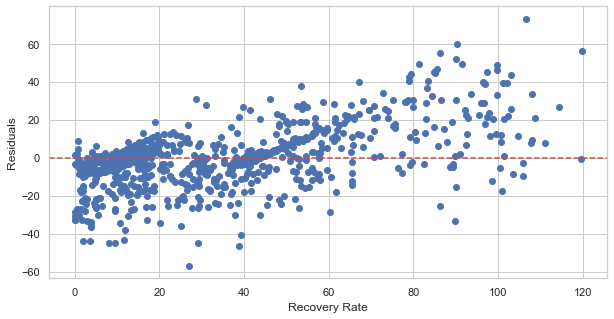

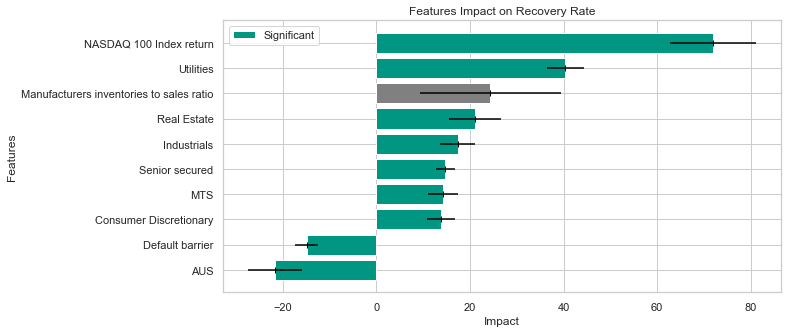

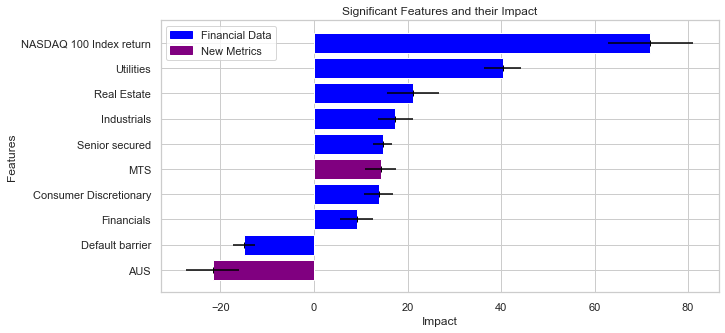

                RR  CBOE DJIA Volatility Index  NASDAQ 100 Index return  \
count  1075.000000                 1075.000000              1075.000000   
mean     34.270877                   25.093079                -0.011592   
std      25.866049                   10.115174                 0.094764   
min       0.001000                   10.470000                -0.157655   
25%      11.801476                   22.000000                -0.153770   
50%      33.157098                   22.000000                 0.013615   
75%      45.341328                   24.890000                 0.085368   
max     119.795491                   63.250000                 0.127178   

       Manufacturers inventories to sales ratio  \
count                               1075.000000   
mean                                   1.349479   
std                                    0.071957   
min                                    1.200000   
25%                                    1.260000   
50%               

In [ ]:
'''COMPOSITE METRICS'''

transformation = 'model_weights'
df = llm_outputs.copy()
#composite_df = compute_scores(df, baseline_model, transformation, False)
#composite_df = expert_weights(df)
composite_df = create_loadings(df)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    + ['MTS', 'CAMI', 'AUS']
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
#final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

print(final_df.describe())

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     73.37
Date:                Tue, 12 Nov 2024   Prob (F-statistic):          2.71e-245
Time:                        21:42:36   Log-Likelihood:                -4375.8
No. Observations:                1075   AIC:                             8820.
Df Residuals:                    1041   BIC:                             8989.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

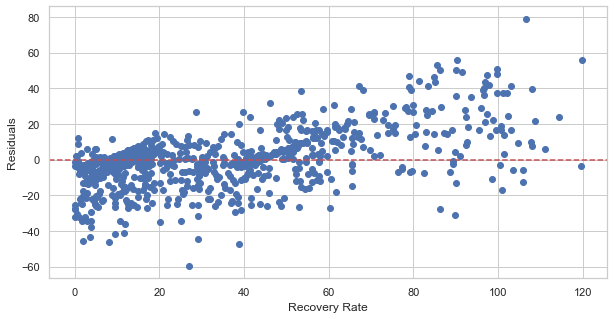

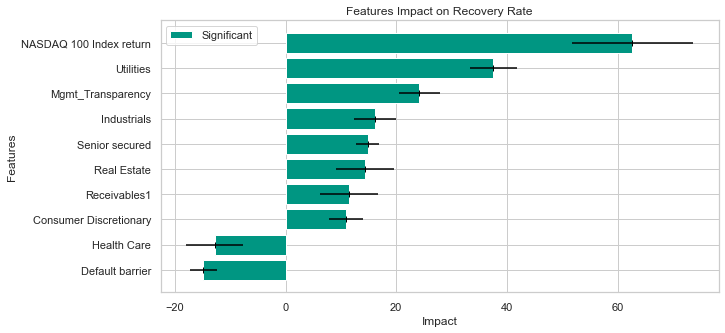

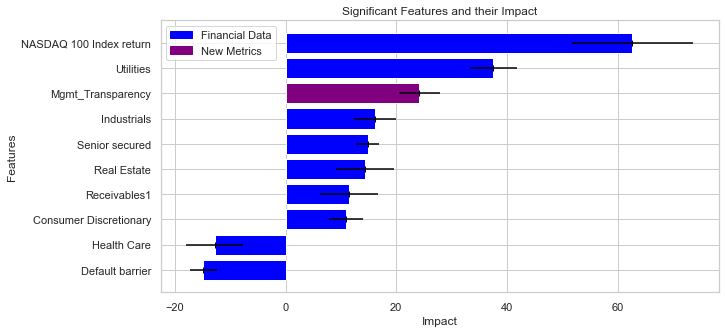

In [ ]:
'''PCA'''

#transformation = 'model_weights'
#df = llm_outputs.copy()
#composite_df = compute_scores(df, baseline_model, transformation)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = df[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    #+ ['MTS', 'CAMI', 'AUS']
                    + ['Mgmt_Transparency', 
                     #'Mgmt_Confidence_Concern_LLM',
                     #'Mgmt_Confidence_Concern_Emotion',
                     'Mgmt_Confidence_Positivity_LLM', 'Mgmt_Concern_Negativity_LLM', 'Mgmt_Confidence_Positivity_Emotion', 'Mgmt_Concern_Negativity_Emotion',
                     'Analyst_Approval_Optimism', 'Analyst_Skepticism_Concern', 
                     #'Analyst_Approval_Skepticism'
                     ]]

# reset index
final_df = final_df.reset_index(drop=True)

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

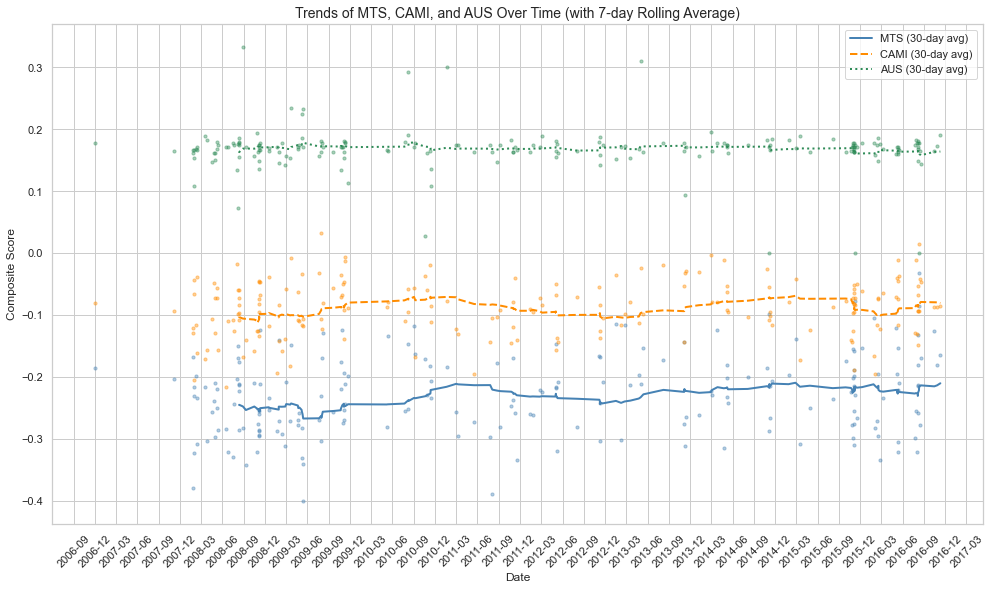

In [432]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

graph_df = composite_df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID']]
graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")

# Convert Date to pandas datetime format if not already done
graph_df['Date'] = pd.to_datetime(graph_df['Date'])

# Calculate rolling averages for smoother trends
graph_df['MTS_Rolling'] = graph_df['MTS'].rolling(window=30).mean()
graph_df['CAMI_Rolling'] = graph_df['CAMI'].rolling(window=30).mean()
graph_df['AUS_Rolling'] = graph_df['AUS'].rolling(window=30).mean()

# Plotting with customized aesthetics
plt.figure(figsize=(14, 8))
plt.plot(graph_df['Date'], graph_df['MTS_Rolling'], label='MTS (30-day avg)', linestyle='-', color='steelblue', linewidth=2)
plt.plot(graph_df['Date'], graph_df['CAMI_Rolling'], label='CAMI (30-day avg)', linestyle='--', color='darkorange', linewidth=2)
plt.plot(graph_df['Date'], graph_df['AUS_Rolling'], label='AUS (30-day avg)', linestyle=':', color='seagreen', linewidth=2)

# Original data as lighter points
plt.scatter(graph_df['Date'], graph_df['MTS'], color='steelblue', alpha=0.4, s=10)
plt.scatter(graph_df['Date'], graph_df['CAMI'], color='darkorange', alpha=0.4, s=10)
plt.scatter(graph_df['Date'], graph_df['AUS'], color='seagreen', alpha=0.4, s=10)

# Formatting the x-axis for date readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adding labels, title, and legend
plt.xlabel('Date', fontsize=12)
plt.ylabel('Composite Score', fontsize=12)
plt.title('Trends of MTS, CAMI, and AUS Over Time (with 7-day Rolling Average)', fontsize=14)
plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


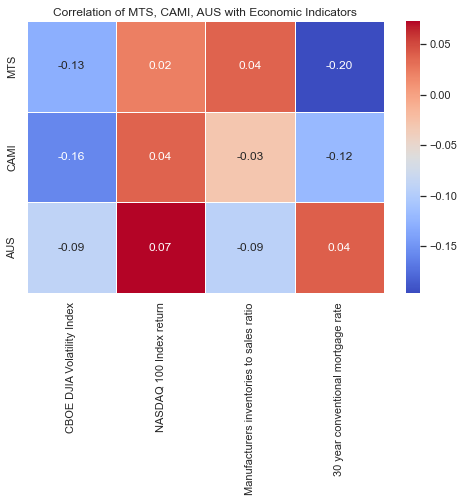

In [433]:
# Reducing the correlation matrix to show only MTS, CAMI, AUS with economic factors
economic_factors = ['CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                    'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

correlation_columns = ['MTS', 'CAMI', 'AUS', 'CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                       'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

graph_df = composite_df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID'] + economic_factors]
graph_df = graph_df.drop_duplicates()

# Calculating correlations
correlation_matrix = graph_df[correlation_columns].corr()

# Selecting only the relevant correlations
reduced_correlation_matrix = correlation_matrix.loc[['MTS', 'CAMI', 'AUS'], economic_factors]

# Plotting the reduced correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of MTS, CAMI, AUS with Economic Indicators")
plt.show()

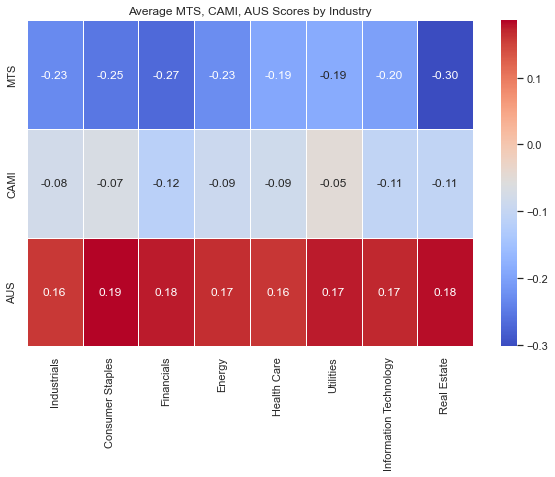

In [434]:
# display avg scores of MTS, CAMI, AUS for 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
graph_df = composite_df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID', 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate']]
graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

industry_scores = {
    'Industrials': graph_df[graph_df['Industrials'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Consumer Staples': graph_df[graph_df['Consumer Staples'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Financials': graph_df[graph_df['Financials'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Energy': graph_df[graph_df['Energy'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Health Care': graph_df[graph_df['Health Care'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Utilities': graph_df[graph_df['Utilities'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Information Technology': graph_df[graph_df['Information Technology'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
    'Real Estate': graph_df[graph_df['Real Estate'] == 1][['MTS', 'CAMI', 'AUS']].mean()
}

industry_scores_df = pd.DataFrame(industry_scores)

# Plotting the average scores for each industry
plt.figure(figsize=(10, 6))
sns.heatmap(industry_scores_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Average MTS, CAMI, AUS Scores by Industry")
plt.show()

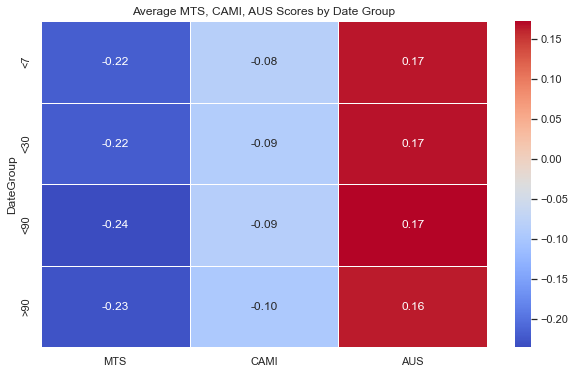

In [435]:
graph_df = composite_df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID', 'Ddate']]
graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

# compute difference between dates
graph_df['Ddate'] = pd.to_datetime(graph_df['Ddate'])
graph_df['Date'] = pd.to_datetime(graph_df['Date'])
graph_df['DateDiff'] = (graph_df['Ddate'] - graph_df['Date']).dt.days

# divide into groups: <7, <30, <90, >90
graph_df['DateGroup'] = pd.cut(graph_df['DateDiff'], bins=[-1, 7, 30, 90, 1000], labels=['<7', '<30', '<90', '>90'])

# calculate average scores for each group
group_scores = graph_df.groupby('DateGroup')[['MTS', 'CAMI', 'AUS']].mean()

# Plotting the average scores for each group
plt.figure(figsize=(10, 6))
sns.heatmap(group_scores, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Average MTS, CAMI, AUS Scores by Date Group")
plt.show()

In [129]:
''''Trade Level Analysis'''

# Load the trade-level data
trade_df = pd.read_csv('dealer/dealer_data_llm_output.csv', index_col=0)
df = trade_df.copy()

In [ ]:
transformation = 'factor'
significant = True
primary_df = compute_scores(trade_df, primary_model, transformation, significant)
non_primary_df = compute_scores(trade_df, non_primary_model, transformation, significant)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     2272.
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:32:14   Log-Likelihood:            -1.0782e+05
No. Observations:               35535   AIC:                         2.157e+05
Df Residuals:                   35505   BIC:                         2.159e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

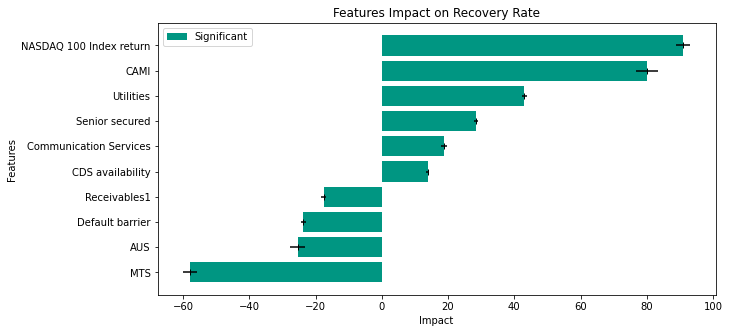

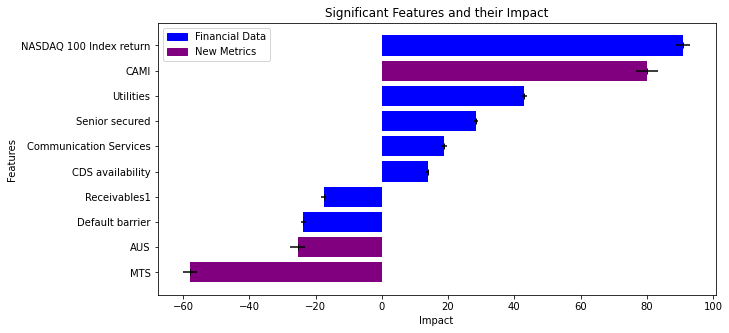

In [152]:
'''New Scores'''

final_df = primary_df[['dealer_RR', 'PrimaryDealer', 'MTS', 'CAMI', 'AUS'] + supporting_features_1 + supporting_features_2]
final_df = final_df[final_df['PrimaryDealer'] == 1]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

create_significant_chart(model)
create_colored_chart(model)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2752.
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:32:14   Log-Likelihood:            -1.8051e+05
No. Observations:               45934   AIC:                         3.611e+05
Df Residuals:                   45904   BIC:                         3.613e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

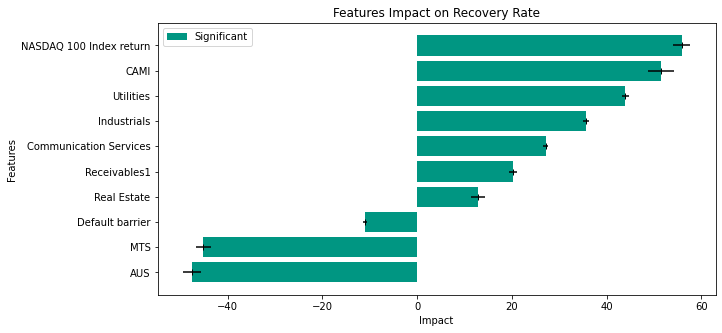

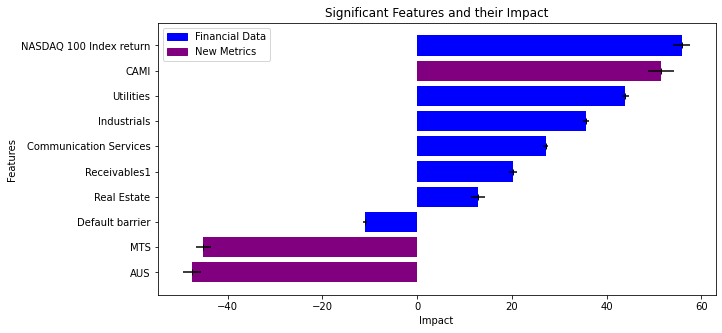

In [153]:
'''New Scores'''

final_df = non_primary_df[['dealer_RR', 'PrimaryDealer', 'MTS', 'CAMI', 'AUS'] + supporting_features_1 + supporting_features_2]
final_df = final_df[final_df['PrimaryDealer'] == 0]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

create_significant_chart(model)
create_colored_chart(model)